In [9]:
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Classes: 40
Samples total: 400
Dimensionality: 4096
Features: 0.0 to 1.0


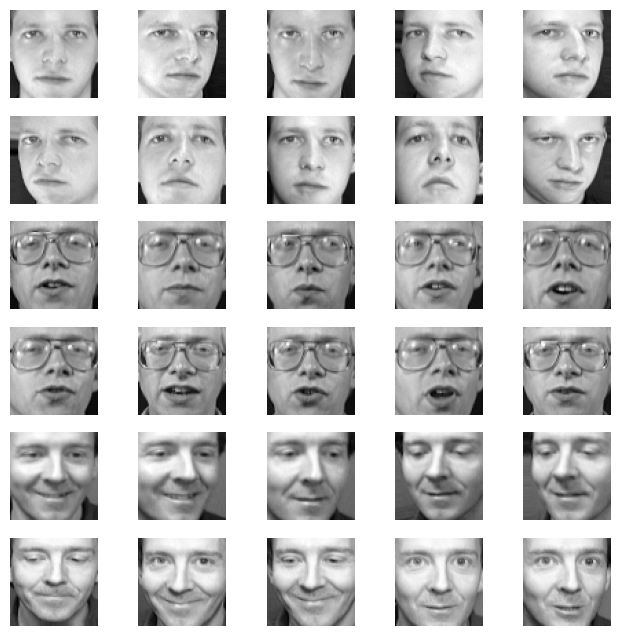

In [2]:
# 指定数据集的下载和缓存文件夹，默认为'~/scikit_learn_data'
data_home = None

# 是否打乱数据集顺序，避免同一个人的图像被分组在一起
shuffle = False

# 随机数生成器的种子，用于数据集的打乱
random_state = 0

# 如果本地没有数据，是否尝试从源站点下载
download_if_missing = True

# 是否返回 (data, target) 对而不是 Bunch 对象
return_X_y = False

# 从AT&T下载并加载 Olivetti faces 数据集
olivetti_faces = fetch_olivetti_faces(data_home=data_home,
                                      shuffle=shuffle,
                                      random_state=random_state,
                                      download_if_missing=download_if_missing,
                                      return_X_y=return_X_y)

# 获取数据，图像和标签
data = olivetti_faces.data
images = olivetti_faces.images
target = olivetti_faces.target

# 获取数据集的描述信息
description = olivetti_faces.DESCR

# 打印数据集的一些信息
print("Classes:", len(set(target)))
print("Samples total:", len(data))
print("Dimensionality:", data.shape[1])
print("Features:", data.min(), "to", data.max())

# 显示数据集中的一些图像
plt.figure(figsize=(8, 8))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
# 加载 Olivetti faces 数据集
rng = np.random.RandomState(0)

faces_data = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces_images = faces_data.images
faces_data_flat = faces_data.data
faces_target = faces_data.target

In [5]:
# 使用 SVM 进行分类
svm_classifier = SVC(kernel='linear', C=1.0)
n_components = 64

In [17]:
def whole_upgrade(n_components,svm_classifier,faces_data_flat=faces_data_flat,faces_target=faces_target,random_state=rng):
  # 使用基础字典学习进行特征提取
  dict_learning = DictionaryLearning(n_components=n_components, random_state=rng)
  start_time = time.time()
  X_transformed1 = dict_learning.fit_transform(faces_data_flat)
  elapsed_time = time.time() - start_time

  # 使用交叉验证计算准确度
  cv_accuracy = cross_val_score(svm_classifier, X_transformed1, faces_target, cv=5)
  #print("Cross-validated Accuracy:", cv_accuracy.mean())
  #print("Training time:", elapsed_time)
  return cv_accuracy.mean(), elapsed_time

In [18]:
def omp_upgrade(n_components,alpha, svm_classifier,faces_data_flat=faces_data_flat,faces_target=faces_target,random_state=rng):
  # 使用 MiniBatchDictionaryLearning 进行字典学习，选择 OMP 方法
  omp_dict_learning = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, transform_algorithm='omp')
  start_time = time.time()
  X_transformed2 = omp_dict_learning.fit_transform(faces_data_flat)
  elapsed_time = time.time() - start_time

  # 使用交叉验证计算准确度
  cv_accuracy = cross_val_score(svm_classifier, X_transformed2, faces_target, cv=5)
  #print("Cross-validated Accuracy:", cv_accuracy.mean())
  #print("Training time:", elapsed_time)
  return cv_accuracy.mean(), elapsed_time

In [15]:
whole_upgrade(n_components,svm_classifier)
omp_upgrade(n_components,alpha =1, svm_classifier=svm_classifier)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=2.846e-04, previous alpha=2.846e-04, with an active set of 11 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


Cross-validated Accuracy: 0.9700000000000001
Training time: 167.44257831573486


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


Cross-validated Accuracy: 0.93
Training time: 36.34217166900635


(0.93, 36.34217166900635)

In [19]:
# 定义参数
n_components_values = np.arange(1, 65)  # 从1到64生成的数组
alpha_values = [0.1, 0.5, 1, 2]
kerneltype = 'linear'
SVM_C = 1.0

# 初始化结果存储
wh_results = {'n': [], 'acy': [], 'time': []}

omp_results = {'0.1': {'n': [], 'acy': [], 'time': []},
               '0.5': {'n': [], 'acy': [], 'time': []},
               '1': {'n': [], 'acy': [], 'time': []},
               '2': {'n': [], 'acy': [], 'time': []}}

# 创建 SVM 分类器
svm_classifier = SVC(kernel=kerneltype, C=SVM_C)

# 循环遍历 n_components_values
for n in n_components_values:
    # 对于 'wh' 方法
    acy_wh, time_wh = whole_upgrade(n, svm_classifier)

    # 存储 'wh' 方法的结果
    wh_results['n'].append(n)
    wh_results['acy'].append(acy_wh)
    wh_results['time'].append(time_wh)

    # 循环遍历 alpha_values
    for a in alpha_values:
        # 对于 'omp' 方法
        acy_omp, time_omp = omp_upgrade(n, a, svm_classifier)

        # 将 alpha 转换为字符串作为字典的键
        a_str = str(a)

        # 存储 'omp' 方法的结果
        omp_results[a_str]['n'].append(n)
        omp_results[a_str]['acy'].append(acy_omp)
        omp_results[a_str]['time'].append(time_omp)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2290: FutureWarning: The default value of batch_size will change from 3 to 256 in 1.3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:

根据警告信息可以看出此时的默认batch_size是3，符合之前的出的结论，因此数据可用。

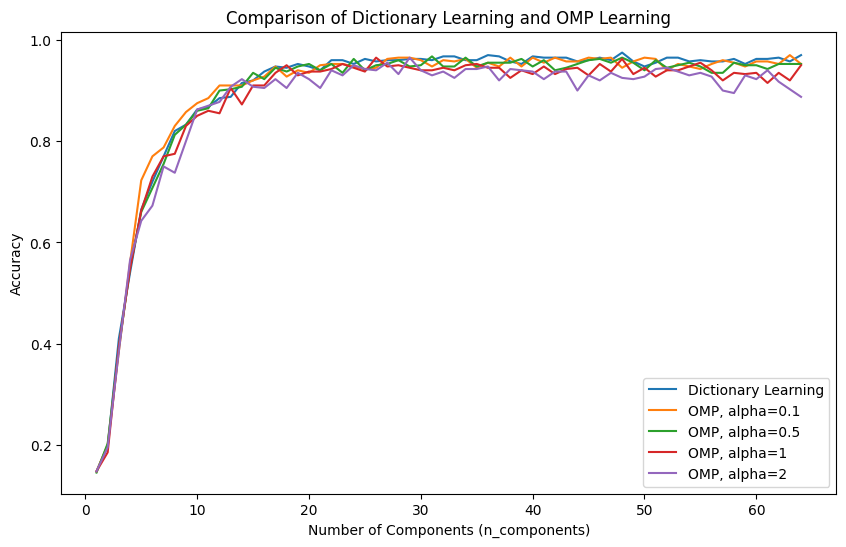

In [35]:
# 提取基础字典学习的结果
dl_n = wh_results['n']
dl_acy = wh_results['acy']
dl_times = wh_results['time']

# 提取不同 alpha 情况下的 OMP 学习的结果
alpha_values = [0.1, 0.5, 1, 2]
omp_lines = []
for a in alpha_values:
    a_str = str(a)
    omp_lines.append({
        'n': omp_results[a_str]['n'],
        'acy': omp_results[a_str]['acy'],
        'time': omp_results[a_str]['time'],
        'label': f'OMP, alpha={a}'
    })

# 绘制图表
plt.figure(figsize=(10, 6))

# 绘制基础字典学习的线
plt.plot(dl_n, dl_acy, label='Dictionary Learning')

# 绘制不同 alpha 情况下的 OMP 学习的线
for line in omp_lines:
    plt.plot(line['n'], line['acy'], label=line['label'])

# 设置图表标题和轴标签
plt.title('Comparison of Dictionary Learning and OMP Learning')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Accuracy')

# 显示图例
plt.legend()

# 显示图表
plt.show()

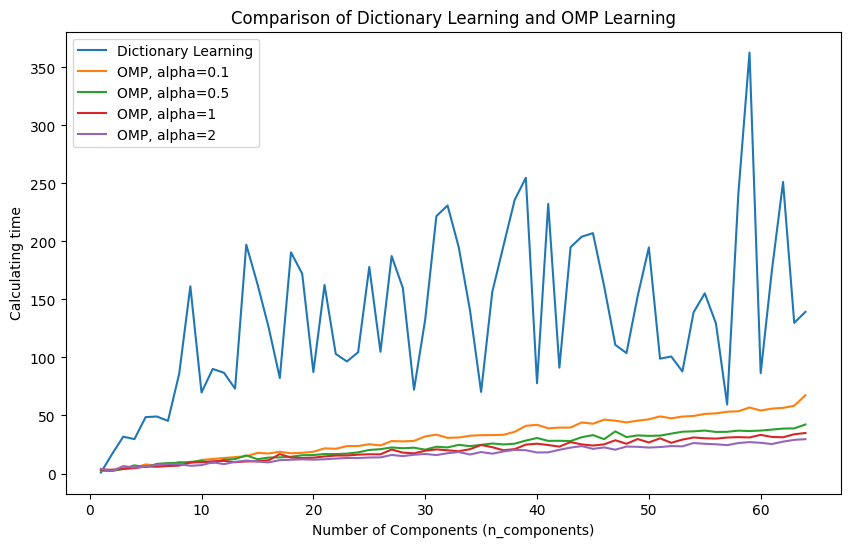

In [36]:
# 绘制图表
plt.figure(figsize=(10, 6))

# 绘制基础字典学习的线
plt.plot(dl_n, dl_times, label='Dictionary Learning')

# 绘制不同 alpha 情况下的 OMP 学习的线
for line in omp_lines:
    plt.plot(line['n'], line['time'], label=line['label'])

# 设置图表标题和轴标签
plt.title('Comparison of Dictionary Learning and OMP Learning')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Calculating time')

# 显示图例
plt.legend()

# 显示图表
plt.show()

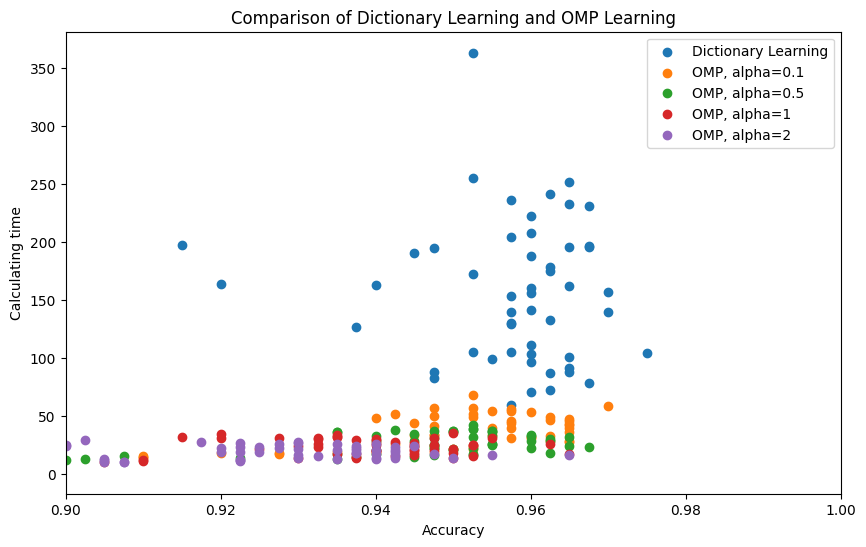

In [50]:
# 绘制图表
plt.figure(figsize=(10, 6))

# 绘制基础字典学习的线
plt.scatter(dl_acy, dl_times, label='Dictionary Learning')

# 绘制不同 alpha 情况下的 OMP 学习的线
for line in omp_lines:
    plt.scatter(line['acy'], line['time'], label=line['label'])

# 设置图表标题和轴标签
plt.title('Comparison of Dictionary Learning and OMP Learning')
plt.xlabel('Accuracy')
plt.xlim(0.9,1)
plt.ylabel('Calculating time')

# 显示图例
plt.legend()

# 显示图表
plt.show()

              whole_upgrade  omp_alpha_0.1  omp_alpha_0.5  omp_alpha_1  \
Max Accuracy        0.97500        0.97000        0.96750      0.96500   
n                  48.00000       63.00000       31.00000     26.00000   
Time (s)          103.76691       58.38875       23.07343     16.52749   

              omp_alpha_2  
Max Accuracy        0.965  
n                  29.000  
Time (s)           16.175  


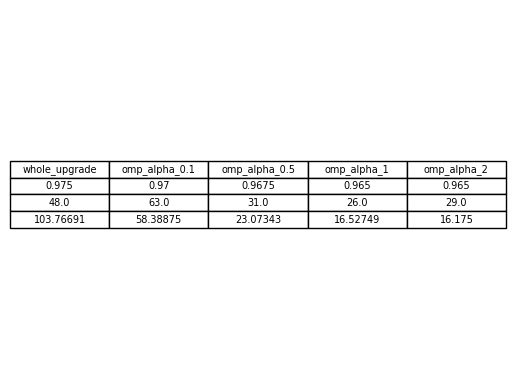

In [33]:
import pandas as pd

# 提取整体升级的最大准确度和对应的 n_components 值和计算时间
max_acy_wh = max(wh_results['acy'])
max_acy_wh_n = wh_results['n'][wh_results['acy'].index(max_acy_wh)]
time_wh = wh_results['time'][wh_results['n'].index(max_acy_wh_n)]

# 提取每个 alpha 对应的最大准确度和对应的 n_components 值和计算时间
max_acy_omp = []
max_acy_omp_n = []
time_omp = []

for a in alpha_values:
    acy_omp_vals = [omp_results[str(a)]['acy'][i] for i in range(len(omp_results[str(a)]['acy']))]
    max_acy_omp.append(max(acy_omp_vals))
    max_acy_omp_n.append(omp_results[str(a)]['n'][acy_omp_vals.index(max_acy_omp[-1])])
    time_omp.append(omp_results[str(a)]['time'][acy_omp_vals.index(max_acy_omp[-1])])

# 创建数据框
data = {
    'whole_upgrade': [max_acy_wh, max_acy_wh_n, time_wh],
}

for i, a in enumerate(alpha_values):
    data[f'omp_alpha_{a}'] = [max_acy_omp[i], max_acy_omp_n[i], time_omp[i]]

df = pd.DataFrame(data, index=['Max Accuracy', 'n', 'Time (s)'])
df = df.round(5)
# 打印数据框
print(df)
fig, ax = plt.subplots()
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

plt.show()